<a href="https://colab.research.google.com/github/ephantusGachomba/AutoInland_Vehicle_Insurance_Claim_Challenge/blob/main/AutoInLand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
import itertools
from collections import Counter
import pandas as pd
from tqdm import tqdm
import numpy as np
import datetime as dt
from tqdm import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, log_loss, classification_report, make_scorer, roc_curve, roc_auc_score
from lightgbm import LGBMClassifier, plot_importance
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
!pip install catboost
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
!pip install category_encoders
from category_encoders import TargetEncoder, CatBoostEncoder, WOEEncoder
from sklearn.pipeline import Pipeline
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

from functools import partial
from hyperopt import hp, fmin, tpe, Trials, space_eval
from hyperopt.pyll.base import scope

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Reading The Files

In [122]:
# Load files into a pandas dataframe
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
submission = pd.read_csv('SampleSubmission.csv')
nigerian_states = pd.read_csv('NigerianStateNames.csv')
variables = pd.read_csv('VariableDefinitions.csv')

In [123]:
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [124]:
test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


In [125]:
print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

The shape of the train set is: (12079, 14)
The shape of the test set is: (1202, 13)


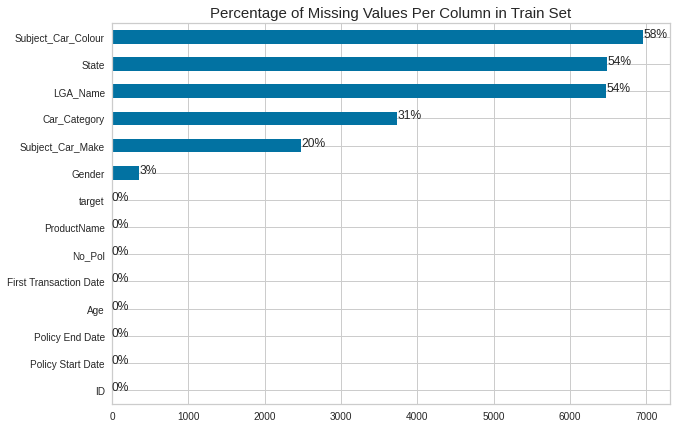

In [126]:
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

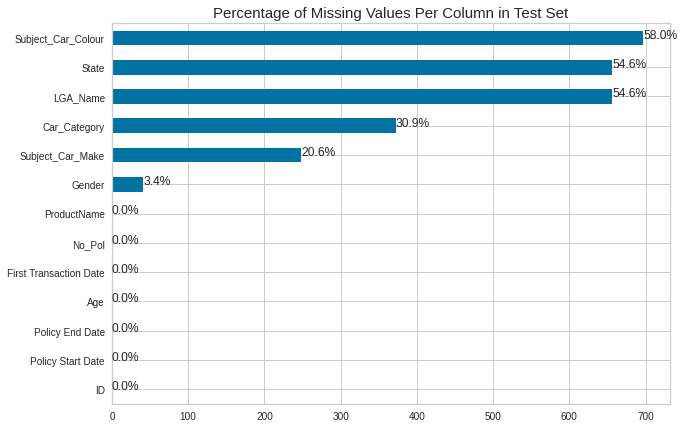

In [127]:
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [128]:
ddd = ['Policy Start Date', 'Policy End Date', 'ProductName', 'Age', 'No_Pol',\
       'Gender', 'Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State']
d = train[train.duplicated(subset=ddd, keep=False)].sort_values(by=ddd+['target'])
d.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
3389,ID_9ZVJVT3,2009-09-13,2011-09-12,Male,62,2009-09-13,2,JEEP,Black,TOYOTA,Surulere,Lagos,Car Classic,0
6917,ID_KRFLCAB,2009-09-13,2011-09-12,Male,62,2009-09-13,2,JEEP,Black,TOYOTA,Surulere,Lagos,Car Classic,1
9533,ID_SILXIAO,2010-01-01,2010-12-31,Entity,20,2010-01-01,4,NaN,As Attached,As Attached,Yaba,Benue,CVTP,0
3750,ID_B5Y8600,2010-01-01,2010-12-31,Entity,20,2010-01-01,4,NaN,As Attached,As Attached,Yaba,Benue,CVTP,1
4795,ID_EF7BPEE,2010-01-01,2010-12-31,NaN,120,2010-01-01,4,NaN,As Attached,TOYOTA,Victoria Island,Lagos,CVTP,0


In [129]:
d[100:120]

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
3162,ID_9CZVVD2,2010-01-11,2011-01-10,Male,43,2010-01-11,1,Shape Of Vehicle Chasis,Black,TOYOTA,Obia/Akpor,Obia-Akpor,Car Classic,0
2860,ID_8KA4D0E,2010-01-11,2011-01-10,Male,43,2010-01-11,1,Shape Of Vehicle Chasis,Black,TOYOTA,Obia/Akpor,Obia-Akpor,Car Classic,1
5587,ID_GTUV0P8,2010-01-12,2011-01-11,Female,60,2010-01-12,2,Saloon,Black,Hyundai,Lagos Mainland,Lagos,Car Classic,0
11239,ID_XL11PM0,2010-01-12,2011-01-11,Female,60,2010-01-12,2,Saloon,Black,Hyundai,Lagos Mainland,Lagos,Car Classic,1
7832,ID_NKX63YC,2010-01-12,2011-01-11,Female,60,2010-01-12,2,NaN,NaN,Hyundai,Lagos Mainland,Lagos,Car Classic,0
10220,ID_UKNNVTR,2010-01-12,2011-01-11,Female,60,2010-01-12,2,NaN,NaN,Hyundai,Lagos Mainland,Lagos,Car Classic,1
287,ID_0VLC38E,2010-01-14,2011-01-13,Male,40,2010-01-14,1,Saloon,NaN,Mercedes,Bwari,Benue,Car Classic,0
6942,ID_KU04WHP,2010-01-14,2011-01-13,Male,40,2010-01-14,1,Saloon,NaN,Mercedes,Bwari,Benue,Car Classic,1
8715,ID_Q3BQERY,2010-01-14,2011-01-13,Entity,40,2010-01-14,4,Saloon,Black,Kia,Ibeju/Lekki,Ibeju-Lekki,Car Classic,0
304,ID_0YNY8IT,2010-01-14,2011-01-13,Entity,40,2010-01-14,4,Saloon,Black,Kia,Ibeju/Lekki,Ibeju-Lekki,Car Classic,1


In [130]:
train = train.sort_values(by=ddd+['target']).drop_duplicates(subset=ddd, keep='last')
train = train.reset_index(drop=True)
train

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_O51ZQ1B,2001-12-11,2011-12-10,Female,37,2001-12-11,1,Saloon,Black,Honda,NaN,NaN,Car Vintage,0
1,ID_VJ1FAVO,2002-03-25,2011-03-24,Male,37,2002-03-25,1,Saloon,Black,TOYOTA,Ekiti,Benue,Car Classic,0
2,ID_ULWS8VL,2003-04-13,2011-04-12,Male,41,2003-04-13,2,Saloon,Black,TOYOTA,Ikeja,Lagos,Car Vintage,0
3,ID_ZYKGSP7,2003-12-21,2034-05-20,Male,48,2003-12-21,2,Saloon,NaN,BMW,NaN,NaN,Car Vintage,0
4,ID_OEWBKGF,2005-08-05,2011-09-29,Female,44,2005-08-05,1,NaN,NaN,Tata,Ajah,Lagos,CVTP,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10888,ID_5H6MECP,2010-12-31,2011-12-30,Female,48,2010-12-31,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
10889,ID_HNCX0NP,2010-12-31,2011-12-30,Male,48,2010-12-31,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe,0
10890,ID_SAFB882,2010-12-31,2011-12-30,Male,48,2010-12-31,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
10891,ID_VX91XCX,2010-12-31,2011-12-30,Female,50,2010-12-31,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0


In [131]:
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (12095, 14)


In [132]:
all_data.tail()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
12090,ID_ZTTHC5X,2010-12-05,2011-12-04,Male,67,2010-12-05,2,JEEP,Black,TOYOTA,Victoria Island,Lagos,Car Classic,NaN
12091,ID_ZUJAFUP,2010-01-14,2011-01-13,Male,43,2010-01-14,1,Saloon,Silver,Hyundai,Surulere,Lagos,Car Classic,NaN
12092,ID_ZWHCTUM,2010-07-26,2011-07-25,Male,30,2010-07-26,1,Truck,White,Iveco,Victoria Island,Lagos,CVTP,NaN
12093,ID_ZWQRL8L,2010-02-16,2011-02-15,Male,44,2010-02-16,2,Saloon,NaN,Nissan,Aba North,Aba-North,Car Classic,NaN
12094,ID_ZWZ92GU,2010-03-18,2011-03-17,Male,28,2010-03-18,1,Saloon,Silver,TOYOTA,NaN,NaN,Car Classic,NaN


In [133]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12095 entries, 0 to 12094
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      12095 non-null  object 
 1   Policy Start Date       12095 non-null  object 
 2   Policy End Date         12095 non-null  object 
 3   Gender                  11760 non-null  object 
 4   Age                     12095 non-null  int64  
 5   First Transaction Date  12095 non-null  object 
 6   No_Pol                  12095 non-null  int64  
 7   Car_Category            8407 non-null   object 
 8   Subject_Car_Colour      5098 non-null   object 
 9   Subject_Car_Make        9601 non-null   object 
 10  LGA_Name                5500 non-null   object 
 11  State                   5489 non-null   object 
 12  ProductName             12095 non-null  object 
 13  target                  10893 non-null  float64
dtypes: float64(1), int64(2), object(11)
me

In [134]:
# Change each column to its appriopriate datatype
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target']]

for col in all_data.columns:
    if col in date_cols:
        all_data[col] = pd.to_datetime(all_data[col])
#     elif col in cat_cols:
#         all_data[col] = all_data[col].astype('category')

# Confirm whether the changes have been applied successfully
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12095 entries, 0 to 12094
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      12095 non-null  object        
 1   Policy Start Date       12095 non-null  datetime64[ns]
 2   Policy End Date         12095 non-null  datetime64[ns]
 3   Gender                  11760 non-null  object        
 4   Age                     12095 non-null  int64         
 5   First Transaction Date  12095 non-null  datetime64[ns]
 6   No_Pol                  12095 non-null  int64         
 7   Car_Category            8407 non-null   object        
 8   Subject_Car_Colour      5098 non-null   object        
 9   Subject_Car_Make        9601 non-null   object        
 10  LGA_Name                5500 non-null   object        
 11  State                   5489 non-null   object        
 12  ProductName             12095 non-null  object

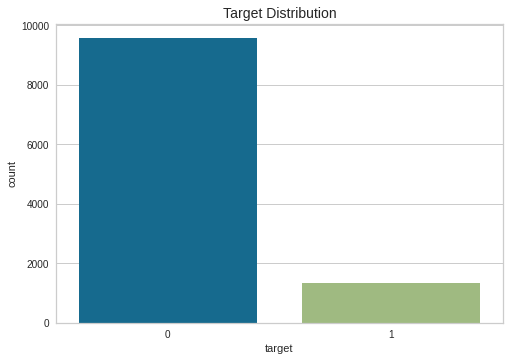

In [135]:
sns.countplot(train.target)
plt.title('Target Distribution', fontdict={'size':14});

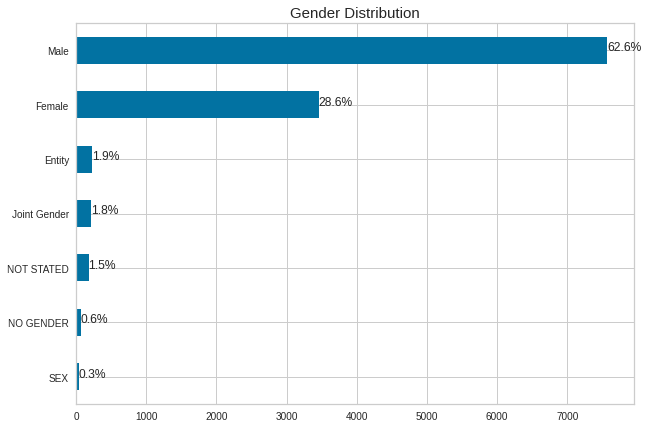

In [136]:
ax = all_data.Gender.value_counts().sort_values().plot(kind = 'barh', figsize=(10,7))
plt.title('Gender Distribution', fontdict={'size': 15})
for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/all_data.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [137]:
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
all_data.Gender = all_data.Gender.replace(mapper)

# Confirm mappings
all_data.Gender.value_counts()

Male      7570
Female    3457
Other      733
Name: Gender, dtype: int64

In [138]:
subject_car_colour_rename = {
    "Dark Grey": "Dark Gray",
    "D. Red": "Dark Red",
    "Gray & Gray": "Gray",
    "D. Gold": "Dark Gold",
    "Blue & Red": "Red & Blue",
    "Yellow & White": "White & Yellow",
    "White & Red": "Red & White",
}

subject_car_make_rename = {
#     ".": "OTHER",
    ".": np.nan,
    "Land Rover.": "Land Rover",
    "Wrangler Jeep": "Jeep"
}

states = {
#     "N-A": "OTHER",
    "N-A": np.nan,
}


all_data.State = all_data.State.replace(states)
all_data.Subject_Car_Colour = all_data.Subject_Car_Colour.replace(subject_car_colour_rename)
all_data.Subject_Car_Make = all_data.Subject_Car_Make.replace(subject_car_make_rename)

In [139]:
all_data.Subject_Car_Colour.value_counts()


Black             1907
Silver             543
Grey               501
As Attached        481
Blue               347
White              293
Red                247
Green              240
Gold               178
Ash                130
Wine                88
Brown               64
Cream                9
Dark Gray            9
Yellow               7
White & Blue         5
Orange               5
B.Silver             4
Purple               4
Dark Red             4
Red & White          3
Gray & Silver        2
Black & Orange       2
Red & Black          2
Light Green          2
Red & Blue           2
Black & White        2
Dark Blue            2
Gray                 2
White & Yellow       2
Red & Yellow         1
Dark Green           1
Burgundy             1
Dark Gold            1
Blue&White&Red       1
Champagne            1
Beige Mitalic        1
Blue Sky             1
Light Blue           1
Light Gray           1
Red Maroon           1
Name: Subject_Car_Colour, dtype: int64

In [140]:
#np.where(condition, returnx true, returny false)
for col in cat_cols:
    all_data[col] = np.where(all_data[col]=='As Attached', np.nan, all_data[col])
    all_data[col] = np.where(all_data[col]=='Other', np.nan, all_data[col])

In [141]:
for col in cat_cols:
    print(col)
    print(all_data[col].unique(), '\n')

Gender
['Female' 'Male' nan] 

Car_Category
['Saloon' nan 'JEEP' 'Truck' 'Mini Van' 'Sedan' 'Shape Of Vehicle Chasis'
 'Bus' 'Station 4 Wheel' 'Pick Up' 'Wagon' 'Mini Bus' 'Motorcycle'
 'CAMRY CAR HIRE' 'Tipper Truck' 'Pick Up > 3 Tons' 'Van'] 

Subject_Car_Colour
['Black' nan 'Gold' 'Red' 'Grey' 'White' 'Dark Blue' 'Silver' 'Blue'
 'Wine' 'Green' 'Ash' 'Brown' 'Cream' 'Yellow' 'Dark Gray' 'Red & Blue'
 'Red & White' 'Orange' 'Dark Red' 'Blue&White&Red' 'Purple' 'Light Gray'
 'Black & Orange' 'Light Blue' 'Red & Black' 'Blue Sky' 'White & Blue'
 'Black & White' 'B.Silver' 'Beige Mitalic' 'Gray' 'Champagne'
 'White & Yellow' 'Red & Yellow' 'Dark Gold' 'Burgundy' 'Light Green'
 'Dark Green' 'Gray & Silver' 'Red Maroon'] 

Subject_Car_Make
['Honda' 'TOYOTA' 'BMW' 'Tata' 'Mack' nan 'Mercedes' 'Lexus' 'Ford'
 'Mitsubishi' 'Hyundai' 'Kia' 'Mazda' 'Nissan' 'Skoda' 'Volkswagen'
 'Black' 'ACURA' 'Pontiac' 'Jeep' 'Lincoln' 'Chevrolet' 'Iveco' 'Peugeot'
 'Dodge' 'Ashok Leyland' 'DAF' 'Range Rover

In [142]:
for col in all_data.columns:
    if col not in ['ID', 'target']:
        all_data[col+"_imputed"] =   np.where(all_data[col].isna(),1,0)
        if col in date_cols+cat_cols:
            all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
        elif col in num_cols:
            all_data[col] = all_data[col].fillna(all_data[col].mean())

# Confirm that there aren't any missing values
all_data[all_data.columns.difference(['target'])].isna().sum()

Age                               0
Age_imputed                       0
Car_Category                      0
Car_Category_imputed              0
First Transaction Date            0
First Transaction Date_imputed    0
Gender                            0
Gender_imputed                    0
ID                                0
LGA_Name                          0
LGA_Name_imputed                  0
No_Pol                            0
No_Pol_imputed                    0
Policy End Date                   0
Policy End Date_imputed           0
Policy Start Date                 0
Policy Start Date_imputed         0
ProductName                       0
ProductName_imputed               0
State                             0
State_imputed                     0
Subject_Car_Colour                0
Subject_Car_Colour_imputed        0
Subject_Car_Make                  0
Subject_Car_Make_imputed          0
dtype: int64

In [143]:
for col in ['Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State']:
    all_data.loc[:, col] = all_data[col].apply(lambda x: x.lstrip())
    all_data.loc[:, col] = all_data[col].apply(lambda x: x.rstrip())
    
for col in ['Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State', 'Gender']:
    all_data.loc[:, col] = all_data[col].apply(lambda x: str(x).lower())
    all_data.loc[:, col] = all_data[col].apply(lambda x: str(x).lower())
    

In [144]:
state_name = {
 'aba-north': 'abia-state',
 'aba-south': 'abia-state',
 'abia': 'abia-state',
 'aboh-mbaise': 'imo-state',
 'abuja': 'capital-fct',
 'abuja-municipal': 'abuja-municipal-area-council',
 'abule-egba': 'alimosho',
 'ado-ekiti': 'ekiti-state',
 'ado-ota': 'ogun-state',
 'ajao-estate': 'oshodi-isolo',
 'ajegunle-state': 'lagos-state',
 'akoko-west': 'ondo-state',
 'akwa-ibom': 'state-akwa-ibom',
 'anambra': 'anambra-state',
 'anambra-east': 'anambra-state',
 'aniocha-south': 'delta-state',
 'asari-toru': 'rivers-state',
 'awka-north': 'anambra-state',
 'awka-south': 'anambra-state',
 'bauchi': 'bauchi-state',
 'bayelsa': 'bayelsa-state',
 'benue': 'benue-state',
 'calabar-municipality': 'cross-river-state',
 'central-abuja': 'capital-fct',
 'cross-river': 'cross-river-state',
 'delta': 'delta-state',
 'ebonyi': 'ebonyi-state',
 'edo': 'edo-state',
 'ekiti-east': 'ekiti-state',
 'ekiti-west': 'ekiti-state',
 'enugu-north': 'enugu-state',
 'enugu-south': 'enugu-state',
 'esan-central': 'edo-state',
 'esan-west': 'edo-state',
 'essien-udim': 'akwa-ibom-state',
 'ethiope-east': 'delta-state',
 'etsako-west': 'edo-state',
 'gombe': 'gombe-state',
 'ibadan-east': 'oyo-state',
 'ibadan-north': 'oyo-state',
 'ibadan-west': 'oyo-state',
 'ibarapa-central': 'oyo-state',
 'idemili-north': 'anambra-state',
 'ifako-ijaye': 'ifako-ijaiye',
 'ife-north': 'osun-state',
 'ijebu-east': 'ogun-state',
 'ijebu-north': 'ogun-state',
 'ijebu-ode': 'ogun-state',
 'ile-oluji': 'ile-oluji-okeigbo',
 'ilesha-east': 'osun-state',
 'ilesha-west': 'osun-state',
 'ilorin-east': 'kwara-state',
 'ilorin-west': 'kwara-state',
 'imo': 'imo-state',
 'isoko-north': 'delta-state',
 'isoko-south': 'delta-state',
 'jos-north': 'plateau-state',
 'jos-south': 'plateau-state',
 'kaduna': 'kaduna-state',
 'kaduna-north': 'kaduna-state',
 'kaduna-south': 'kaduna-state',
 'kano': 'kano-state',
 'kano-municipal': 'kano-state',
 'kebbi': 'kebbi-state',
 'kogi': 'kogi-state',
 'kwara': 'kwara-state',
 'lagelu-north': 'oyo-state',
 'lagos': 'lagos-state',
 'nasarawa': 'nasarawa-state',
 'ndokwa-east': 'delta-state',
 'nnewi-south': 'anambra-state',
 'nsit-ubium': 'akwa-ibom-state',
 'obia-akpor': 'rivers-state',
 'ogba-ndoni': 'rivers-state',
 'ogbmosho-south': 'oyo-state',
 'ogun': 'ogun-state',
 'ogun-waterside': 'ogun-state',
 'ondo': 'ondo-state',
 'ondo-west': 'ondo-state',
 'onitsha-north': 'anambra-state',
 'orile-iganmu': 'surulere',
 'osun': 'osun-state',
 'other': 'other',
 'ovia-southwest': 'edo-state',
 'owerri-municipal': 'imo-state',
 'owerri-north': 'imo-state',
 'owerri-west': 'imo-state',
 'oyo': 'oyo-state',
 'oyo-east': 'oyo-state',
 'oyo-west': 'oyo-state',
 'port-harcourt': 'rivers-state',
 'quaan-pan': 'qua-an-pan',
 'rivers': 'rivers-state',
 'udi-agwu': 'udi',
 'ughelli-north': 'delta-state',
 'umuahia-south': 'abia-state',
 'warri-central': 'delta-state',
 'warri-north': 'delta-state'}

lga_name = {
 'ado-odo/ota': 'ado',
 'ajegunle,lagos--state': 'ajeromi-ifelodun',
 'bekwara': 'bekwarra',
 'calabar-municipality': 'calabar',
 'central-area,-abuja': 'abuja',
 'ibeju/lekki': 'ibeju',
 'ifako-ijaye': 'ifako-ijaiye',
 'ikeja-g.r.a': 'ikeja',
 'ilesha-east': 'ilesha',
 'ilesha-west': 'ilesha',
 'obia/akpor': 'obio-akpor',
 'ogba': 'ogba-egbema-ndoni',
 'ogba/egbema/ndoni': 'ogba-egbema-ndoni',
 'ogbmosho-south': 'ogbomoso',
 'ogudu': 'obudu',
 'okpe,-delta-state': 'okpe',
 'olamabolo': 'olamaboro',
 'ovia-southwest': 'ovia-south-west',
 'somolu': 'shomolu'}

all_data.State = all_data.State.replace(state_name)
all_data.LGA_Name = all_data.State.replace(lga_name)

all_data.replace(' ', '-', regex=True, inplace=True)
    

In [145]:
all_data.columns

Index(['ID', 'Policy Start Date', 'Policy End Date', 'Gender', 'Age',
       'First Transaction Date', 'No_Pol', 'Car_Category',
       'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State',
       'ProductName', 'target', 'Policy Start Date_imputed',
       'Policy End Date_imputed', 'Gender_imputed', 'Age_imputed',
       'First Transaction Date_imputed', 'No_Pol_imputed',
       'Car_Category_imputed', 'Subject_Car_Colour_imputed',
       'Subject_Car_Make_imputed', 'LGA_Name_imputed', 'State_imputed',
       'ProductName_imputed'],
      dtype='object')

In [146]:
agg_cols = [x for x in all_data.columns if x not in ['ID', 'target']]
aggs =[np.mean, np.max, pd.Series.skew, pd.Series.kurtosis, np.std, np.median]
new_agg = list()
for col in agg_cols:
    if '_imputed' not in col:
        temp1 = all_data.groupby(col)['No_Pol'].agg(aggs)
        temp2 = all_data.groupby(col)['Age'].agg(aggs)
        
        for agg in temp1.keys():
            all_data[f'{col}_No_Pol_{agg}'] = all_data[col].map(temp1.to_dict()[agg])
            new_agg.append(f'{col}_No_Pol_{agg}')
        
        for agg in temp2.keys():
            all_data[f'{col}_Age_{agg}'] = all_data[col].map(temp2.to_dict()[agg])
            new_agg.append(f'{col}_Age_{agg}')

In [147]:
for col in new_agg:
    all_data[col] = all_data[col].fillna(all_data[col].mean())

In [148]:
def age_bins(x):
    if x < 18:
        return 'young'
    elif x >= 18 and x <36:
        return 'young Adult'
    elif x >=36 and x < 56:
        return 'Adult'
    elif x >= 56:
        return 'senior'
    
def car_category_bins(x):
    

    load = [ 'truck', 'tipper-truck', 'pick-up->-3-tons', 'shape-of-vehicle-chasis']
    passenger = ['saloon', 'jeep', 'bus', 'mini-bus','motorcycle', 'sedan', 'wagon', 'camry-car-hire', 'van', 'mini-van']
    both = ['station-4-wheel', 'pick-up']
    
    if x in load:
        return 'load'
    elif x in passenger:
        return 'passenger'
    elif x in both:
        return 'both'

def car_size(x):
    
    small = ['motorcycle', 'shape-of-vehicle-chasis']
    medium = ['saloon', 'sedan', 'camry-car-hire']
    large = ['truck', 'pick-up', 'van', 'mini-bus', 'wagon', 'mini-van', 'jeep']
    extra_large = ['pick-up->-3-tons', 'tipper-truck', 'station-4-wheel', 'bus']
    
    if x in small:
        return 'small'
    if x in medium:
        return 'medium'
    if x in large:
        return 'large'
    if x in extra_large:
        return 'extra_large'

all_data['age_bins'] = all_data['Age'].apply(age_bins)
all_data['car_size'] = all_data['Car_Category'].apply(car_size)
all_data['car_category_bins'] = all_data['Car_Category'].apply(car_category_bins)

feature_bins = ['car_category_bins', 'car_size', 'age_bins']
# feature_bins = []

In [149]:
for col in date_cols:
    if col not in ['First Transaction Date']:
        all_data.loc[:, 'weekend'+'_'+col] = (all_data[col].dt.weekday >=5).astype(int)
        all_data.loc[:, 'weeknum'+'_'+col] = all_data[col].dt.strftime('%W').astype(int)
        for date_feature in ['year', 'month', 'day', 'quarter', 'weekday']:
            all_data[col+"_"+date_feature] = getattr(all_data[col].dt, date_feature)
            
all_data.loc[:,'policy_duration_weeks']=round((all_data['Policy End Date']\
                                                 -all_data['Policy Start Date'])/np.timedelta64(1, 'W'))
all_data.loc[:,'policy_duration_months']=round((all_data['Policy End Date']\
                                                  -all_data['Policy Start Date'])/np.timedelta64(1, 'M'))
all_data.loc[:,'policy_duration_days']=round((all_data['Policy End Date']\
                                                -all_data['Policy Start Date'])/np.timedelta64(1, 'D'))
all_data.loc[:,'policy_duration_years']=round((all_data['Policy End Date']\
                                                -all_data['Policy Start Date'])/np.timedelta64(1, 'Y'))

all_data.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,...,weeknum_Policy End Date,Policy End Date_year,Policy End Date_month,Policy End Date_day,Policy End Date_quarter,Policy End Date_weekday,policy_duration_weeks,policy_duration_months,policy_duration_days,policy_duration_years
0,ID_O51ZQ1B,2001-12-11,2011-12-10,female,37,2001-12-11,1,saloon,black,honda,...,49,2011,12,10,4,5,522.0,120.0,3651.0,10.0
1,ID_VJ1FAVO,2002-03-25,2011-03-24,male,37,2002-03-25,1,saloon,black,toyota,...,12,2011,3,24,1,3,469.0,108.0,3286.0,9.0
2,ID_ULWS8VL,2003-04-13,2011-04-12,male,41,2003-04-13,2,saloon,black,toyota,...,15,2011,4,12,2,1,417.0,96.0,2921.0,8.0
3,ID_ZYKGSP7,2003-12-21,2034-05-20,male,48,2003-12-21,2,saloon,black,bmw,...,20,2034,5,20,2,5,1587.0,365.0,11108.0,30.0
4,ID_OEWBKGF,2005-08-05,2011-09-29,female,44,2005-08-05,1,saloon,black,tata,...,39,2011,9,29,3,3,321.0,74.0,2246.0,6.0


In [150]:
# (we subtract 1 e.g to make months range 0 to 11)
for col in all_data.columns:
    if col not in ['First Transaction Date']+date_cols+num_cols+['ID', 'target']+cat_cols:
        if '_month' in col:
            all_data[f'{col}_sin'] = np.sin((all_data[col] - 1) * (2. * np.pi / 12.))
            all_data[f'{col}_cos'] = np.cos((all_data[col] - 1) * (2. * np.pi / 12.))
        elif '_day' in col:
            all_data[f'{col}_sin'] = np.sin((all_data[col] - 1) * (2. * np.pi / 31.))
            all_data[f'{col}_cos'] = np.cos((all_data[col] - 1) * (2. * np.pi / 31.))

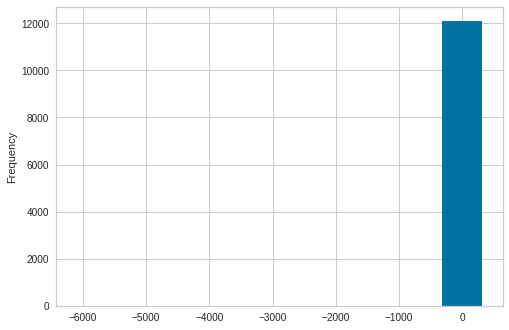

In [151]:
all_data.Age.plot(kind='hist')

In [152]:
all_data.Age.unique()

array([   37,    41,    48,    44,    45,    39,    31,    62,    50,
          20,   120,    27,    32,    33,    70,    47,    36,    53,
          51,    93,    15,    34,    35,    40,    42,    61,    64,
          66,    30,     1,    25,    57,    82,    38,    65,    43,
          54,    60,     6,    28,    46,    52,    24,    29,    49,
          69,    81,    67,    55,    85,    56,    63,    78,    80,
          23,    26,    58,    68,     3,     4,    71,    76,    12,
       -5939,    59,     5,    75,    73,    77,    89,   320,     2,
          21,    79,    72,     7,    84,    18,    10,     9,    83,
         100,    11,     8,    74,   -26,    22,    -2,   133,    86,
          19,   112,    13,   -27,   -12,   -76,    90,    14,   128,
         -22,     0,   144,   -51, -6099,    16,   102,   140,    17,
          87,    88])

In [153]:
all_data.Age = all_data.Age.abs()
all_data['log_age'] = np.log10(all_data['Age'] + 1)
age = {
    5939: 59,
    6099: 60,
    320: 32
}
all_data.Age = all_data.Age.replace(age)
all_data.Age.unique()

array([ 37,  41,  48,  44,  45,  39,  31,  62,  50,  20, 120,  27,  32,
        33,  70,  47,  36,  53,  51,  93,  15,  34,  35,  40,  42,  61,
        64,  66,  30,   1,  25,  57,  82,  38,  65,  43,  54,  60,   6,
        28,  46,  52,  24,  29,  49,  69,  81,  67,  55,  85,  56,  63,
        78,  80,  23,  26,  58,  68,   3,   4,  71,  76,  12,  59,   5,
        75,  73,  77,  89,   2,  21,  79,  72,   7,  84,  18,  10,   9,
        83, 100,  11,   8,  74,  22, 133,  86,  19, 112,  13,  90,  14,
       128,   0, 144,  16, 102, 140,  17,  87,  88])

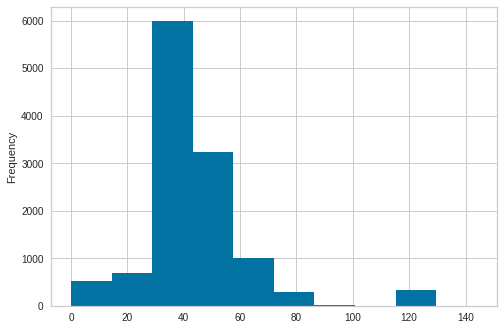

In [154]:
all_data.Age.plot(kind='hist')

In [155]:
q25, q75 = np.percentile(all_data['Age'], 25), np.percentile(all_data['Age'], 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
f_iqr = q75 - q25
print('iqr: {}'.format(f_iqr))

f_cut_off = f_iqr * 1.5
f_lower, f_upper = q25 - f_cut_off, q75 + f_cut_off
print('Cut Off: {}'.format(f_cut_off))
print('{} Lower: {}'.format('Age', f_lower))
print('{} Upper: {}'.format('Age', f_upper))

outliers = [x for x in all_data.Age.values if x < f_lower or x > f_upper]
print('Feature {} Outliers: {}'.format('Age', len(outliers)))
print('{} outliers:{}'.format('Age', outliers))

median_upper = all_data.loc[all_data['Age'] > f_upper, 'Age'].median()
median_lower = all_data.loc[all_data['Age'] < f_lower, 'Age'].median()
print('median_lower: {}'.format(median_lower))
print('median_upper: {}'.format(median_upper))

# all_data['Age'] = np.where(all_data['Age'] > f_upper, median_upper, all_data['Age'])
# all_data['Age'] = np.where(all_data['Age'] < f_lower, median_lower, all_data['Age'])

# all_data['Age'] = round(all_data['Age'], 1)

Quartile 25: 35.0 | Quartile 75: 50.0
iqr: 15.0
Cut Off: 22.5
Age Lower: 12.5
Age Upper: 72.5
Feature Age Outliers: 1128
Age outliers:[120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 93, 93, 93, 93, 120, 1, 1, 82, 6, 1, 120, 120, 81, 81, 120, 120, 1, 120, 85, 120, 78, 80, 80, 1, 120, 120, 1, 120, 120, 120, 120, 3, 120, 120, 120, 4, 6, 76, 12, 12, 12, 12, 12, 12, 12, 12, 12, 4, 12, 1, 5, 1, 1, 120, 120, 1, 75, 12, 12, 6, 73, 77, 77, 120, 89, 2, 79, 7, 7, 120, 1, 1, 2, 2, 82, 1, 1, 120, 1, 2, 7, 77, 1, 1, 2, 12, 120, 3, 2, 80, 84, 84, 120, 120, 120, 120, 10, 73, 75, 79, 10, 1, 3, 9, 3, 89, 1, 1, 83, 83, 1, 1, 1, 1, 83, 120, 100, 76, 120, 120, 120, 1, 78, 12, 12, 12, 12, 12, 12, 120, 1, 2, 6, 11, 11, 76, 76, 81, 73, 1, 8, 74, 120, 120, 5, 7, 11, 1, 1, 3, 120, 120, 120, 120, 120, 1, 1, 120, 1, 1, 10, 10, 10, 10, 120, 76, 76, 76, 10, 10, 3, 78, 120, 80, 120, 120, 78, 81, 76, 7, 5, 5, 5, 5, 84, 1, 3, 1, 2, 84, 12, 12, 12, 12, 12, 12, 12, 12, 80, 75, 1, 6, 120, 1, 1

In [156]:
cat_cols

['Gender',
 'Car_Category',
 'Subject_Car_Colour',
 'Subject_Car_Make',
 'LGA_Name',
 'State',
 'ProductName']

In [157]:
c = cat_cols+num_cols
combn2 = list(itertools.combinations(c, 2))
combn_cols2 = list()
for c1, c2 in combn2:
    combn_cols2.append(c1+"_"+c2)
    all_data.loc[:, c1+"_"+c2] = all_data[c1].astype(str)+"_"+all_data[c2].astype(str)
    
combn_num = list(itertools.combinations(['Age', 'No_Pol'], 2))
for c1, c2 in combn_num:
    all_data.loc[:, c1+"_add_"+c2] = all_data[c1].astype('int32')+all_data[c2].astype('int32')
    all_data.loc[:, c1+"_mul_"+c2] = all_data[c1].astype('int32')*all_data[c2].astype('int32')
    all_data.loc[:, c1+"_sub_"+c2] = all_data[c1].astype('int32')-all_data[c2].astype('int32')
    all_data.loc[:, c2+"_sub_"+c1] = all_data[c2].astype('int32')-all_data[c1].astype('int32')

In [158]:
combn3 = list(itertools.combinations(c, 3))
combn_cols3 = list()
for c1, c2, c3 in combn3:
    combn_cols3.append(c1+"_"+c2+"_"+c3)
    all_data.loc[:, c1+"_"+c2+"_"+c3] = all_data[c1].astype(str)+"_"+all_data[c2].astype(str)+"_"+all_data[c3].astype(str)
    
# combn4 = list(itertools.combinations(c, 4))
# combn_cols4 = list()
# for c1, c2, c3, c4 in combn4:
#     combn_cols4.append(c1+"_"+c2+"_"+c3+"_"+c4)
#     all_data.loc[:, c1+"_"+c2+"_"+c3+"_"+c4] = all_data[c1].astype(str)+"_"+all_data[c2].astype(str)+"_"+all_data[c3].astype(str)\
#     +"_"+all_data[c4].astype(str)
    
# combn5 = list(itertools.combinations(c, 5))
# combn_cols5 = list()
# for c1, c2, c3, c4, c5 in combn5:
#     combn_cols5.append(c1+"_"+c2+"_"+c3+"_"+c4)
#     all_data.loc[:, c1+"_"+c2+"_"+c3+"_"+c4] = all_data[c1].astype(str)+"_"+all_data[c2].astype(str)+"_"+all_data[c3].astype(str)\
#     +"_"+all_data[c4].astype(str)+"_"+all_data[c5].astype(str)

In [159]:
cat_cols = cat_cols+feature_bins+combn_cols2+combn_cols3

In [160]:
all_data.head()


,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,...,LGA_Name_State_ProductName,LGA_Name_State_Age,LGA_Name_State_No_Pol,LGA_Name_ProductName_Age,LGA_Name_ProductName_No_Pol,LGA_Name_Age_No_Pol,State_ProductName_Age,State_ProductName_No_Pol,State_Age_No_Pol,ProductName_Age_No_Pol
0,ID_O51ZQ1B,2001-12-11,2011-12-10,female,37,2001-12-11,1,saloon,black,honda,...,lagos-state_lagos-state_Car-Vintage,lagos-state_lagos-state_37,lagos-state_lagos-state_1,lagos-state_Car-Vintage_37,lagos-state_Car-Vintage_1,lagos-state_37_1,lagos-state_Car-Vintage_37,lagos-state_Car-Vintage_1,lagos-state_37_1,Car-Vintage_37_1
1,ID_VJ1FAVO,2002-03-25,2011-03-24,male,37,2002-03-25,1,saloon,black,toyota,...,benue-state_benue-state_Car-Classic,benue-state_benue-state_37,benue-state_benue-state_1,benue-state_Car-Classic_37,benue-state_Car-Classic_1,benue-state_37_1,benue-state_Car-Classic_37,benue-state_Car-Classic_1,benue-state_37_1,Car-Classic_37_1
2,ID_ULWS8VL,2003-04-13,2011-04-12,male,41,2003-04-13,2,saloon,black,toyota,...,lagos-state_lagos-state_Car-Vintage,lagos-state_lagos-state_41,lagos-state_lagos-state_2,lagos-state_Car-Vintage_41,lagos-state_Car-Vintage_2,lagos-state_41_2,lagos-state_Car-Vintage_41,lagos-state_Car-Vintage_2,lagos-state_41_2,Car-Vintage_41_2
3,ID_ZYKGSP7,2003-12-21,2034-05-20,male,48,2003-12-21,2,saloon,black,bmw,...,lagos-state_lagos-state_Car-Vintage,lagos-state_lagos-state_48,lagos-state_lagos-state_2,lagos-state_Car-Vintage_48,lagos-state_Car-Vintage_2,lagos-state_48_2,lagos-state_Car-Vintage_48,lagos-state_Car-Vintage_2,lagos-state_48_2,Car-Vintage_48_2
4,ID_OEWBKGF,2005-08-05,2011-09-29,female,44,2005-08-05,1,saloon,black,tata,...,lagos-state_lagos-state_CVTP,lagos-state_lagos-state_44,lagos-state_lagos-state_1,lagos-state_CVTP_44,lagos-state_CVTP_1,lagos-state_44_1,lagos-state_CVTP_44,lagos-state_CVTP_1,lagos-state_44_1,CVTP_44_1


In [161]:
all_data.Gender_Car_Category

0        female_saloon
1          male_saloon
2          male_saloon
3          male_saloon
4        female_saloon
             ...      
12090        male_jeep
12091      male_saloon
12092       male_truck
12093      male_saloon
12094      male_saloon
Name: Gender_Car_Category, Length: 12095, dtype: object

In [162]:
cat_cols

['Gender',
 'Car_Category',
 'Subject_Car_Colour',
 'Subject_Car_Make',
 'LGA_Name',
 'State',
 'ProductName',
 'car_category_bins',
 'car_size',
 'age_bins',
 'Gender_Car_Category',
 'Gender_Subject_Car_Colour',
 'Gender_Subject_Car_Make',
 'Gender_LGA_Name',
 'Gender_State',
 'Gender_ProductName',
 'Gender_Age',
 'Gender_No_Pol',
 'Car_Category_Subject_Car_Colour',
 'Car_Category_Subject_Car_Make',
 'Car_Category_LGA_Name',
 'Car_Category_State',
 'Car_Category_ProductName',
 'Car_Category_Age',
 'Car_Category_No_Pol',
 'Subject_Car_Colour_Subject_Car_Make',
 'Subject_Car_Colour_LGA_Name',
 'Subject_Car_Colour_State',
 'Subject_Car_Colour_ProductName',
 'Subject_Car_Colour_Age',
 'Subject_Car_Colour_No_Pol',
 'Subject_Car_Make_LGA_Name',
 'Subject_Car_Make_State',
 'Subject_Car_Make_ProductName',
 'Subject_Car_Make_Age',
 'Subject_Car_Make_No_Pol',
 'LGA_Name_State',
 'LGA_Name_ProductName',
 'LGA_Name_Age',
 'LGA_Name_No_Pol',
 'State_ProductName',
 'State_Age',
 'State_No_Pol',
 'P

In [163]:
for col in cat_cols:
    frequencies = all_data[col].value_counts(normalize=True)
    mapping = all_data[col].map(frequencies)
    all_data[col+"_israre"] = np.where(mapping < 0.01, 1, 0)
    

# all_data[col] = all_data[col].mask(all_data[col].map(all_data[col].value_counts(normalize=True)) < 0.01, 'rare')

In [164]:
%%time
ss = [x for x in all_data.columns if x not in ['ID', 'target']+date_cols]
all_data['sum'] = all_data[ss].sum(axis=1)  
all_data['min'] = all_data[ss].min(axis=1)
all_data['max'] = all_data[ss].max(axis=1)
all_data['mean'] = all_data[ss].mean(axis=1)
all_data['std'] = all_data[ss].std(axis=1)
all_data['skew'] = all_data[ss].skew(axis=1)
all_data['kurt'] = all_data[ss].kurtosis(axis=1)
all_data['med'] = all_data[ss].median(axis=1)
all_data['range'] = all_data['max']-all_data['min']

CPU times: user 5.46 s, sys: 182 ms, total: 5.64 s
Wall time: 5.69 s


In [165]:
main_cols = all_data.columns.difference(date_cols+['ID', 'target']).tolist()
# scaler = StandardScaler()
# all_data[main_cols] = scaler.fit_transform(all_data[main_cols])

In [166]:
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((10893, 467), (1202, 467))

In [167]:
te = WOEEncoder(cols=cat_cols)
train_df = te.fit_transform(train_df, train_df.target)
test_df = te.transform(test_df)

In [168]:
# train_df[~train_df.isin([np.nan, np.inf, -np.inf]).any(1)]


In [169]:
scaler = StandardScaler()
power = PowerTransformer()
pipeline = Pipeline(steps=[('s', scaler),('p', power)])
train_df[main_cols] = pipeline.fit_transform(train_df[main_cols])
test_df[main_cols] = pipeline.transform(test_df[main_cols])

In [170]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [171]:
# %%time
# kmeans = KMeans(init='k-means++', n_init=10, random_state=42)
# ssd = []
# K = range(1, 15)

# for k in K:
#     kmeans = KMeans(n_clusters=k).fit(train_df[main_cols])
#     ssd.append(kmeans.inertia_)

# ssd

# plt.plot(K, ssd, "bx-")
# plt.xlabel("Distance Residual Sums for K Values (WCSS)")
# plt.title("Elbow Method for Optimum Number of Clusters")
# plt.show()

# kmeans = KMeans(init='k-means++', n_init=10, random_state=42)
# visu = KElbowVisualizer(kmeans, k=(2, 15))
# visu.fit(train_df[main_cols])
# visu.show()

In [172]:
# kmeans = KMeans(init='k-means++', n_init=10, n_clusters=7).fit(train_df[main_cols])
# clusters = kmeans.labels_
# train_df['cluster'] = clusters
# test_df['cluster'] = kmeans.predict(test_df[main_cols])
# main_cols.append('cluster')

In [173]:
corr_matrix = train_df[main_cols].corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

print('There are {} correlated columns to remove.'.format(len(to_drop)))
print(to_drop)

There are 169 correlated columns to remove.
['Age_Age_mean', 'Age_Age_median', 'Age_add_No_Pol', 'Age_sub_No_Pol', 'Car_Category_Age_kurt', 'Car_Category_Age_median', 'Car_Category_Age_skew', 'Car_Category_Age_std', 'Car_Category_LGA_Name_State', 'Car_Category_LGA_Name_israre', 'Car_Category_No_Pol_amax', 'Car_Category_No_Pol_kurt', 'Car_Category_No_Pol_skew', 'Car_Category_ProductName_No_Pol', 'Car_Category_State', 'Car_Category_State_Age', 'Car_Category_State_Age_israre', 'Car_Category_State_No_Pol', 'Car_Category_State_No_Pol_israre', 'Car_Category_State_ProductName', 'Car_Category_State_ProductName_israre', 'Car_Category_State_israre', 'Car_Category_Subject_Car_Colour_State', 'Car_Category_Subject_Car_Colour_State_israre', 'Car_Category_Subject_Car_Make_State', 'Car_Category_Subject_Car_Make_State_israre', 'Car_Category_israre', 'Gender_Age_kurt', 'Gender_Age_mean', 'Gender_Age_median', 'Gender_Age_skew', 'Gender_Age_std', 'Gender_Car_Category_ProductName', 'Gender_Car_Category_Sta

In [174]:
len(list(set(main_cols).difference(to_drop)))

293

In [175]:
main_cols = list(set(main_cols).difference(to_drop))

In [176]:
df_train = train_df.drop(['target']+to_drop, 1).copy()
df_test = test_df.drop(['target']+to_drop, 1).copy()
df_train['dataset_label'] = 0
df_test['dataset_label'] = 1
target = 'dataset_label'

n_val = int((train_df.shape[0] + test_df.shape[0] )*0.15)
n_val


1814

In [177]:
def create_adversarial_data(df_train, df_test, cols, N_val=n_val):
    df_master = pd.concat([df_train[cols], df_test[cols]], axis=0)
    adversarial_test = df_master.sample(N_val, replace=False)
    adversarial_train = df_master[~df_master.index.isin(adversarial_test.index)]
    return adversarial_train, adversarial_test

In [178]:
# features = [x for x in df_train.columns if x not in ['ID', 'target', 'dataset_label']]
features = main_cols
all_cols = features + [target]
adversarial_train, adversarial_test = create_adversarial_data(df_train, df_test, all_cols)
adversarial_train.shape, adversarial_test.shape

((10281, 294), (1814, 294))

In [179]:
train_data = Pool(
    data=adversarial_train[features],
    label=adversarial_train[target],
#     cat_features=cat_cols
)
holdout_data = Pool(
    data=adversarial_test[features],
    label=adversarial_test[target],
#     cat_features=cat_cols
)

model = CatBoostClassifier()
_ = model.fit(train_data, eval_set=holdout_data, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

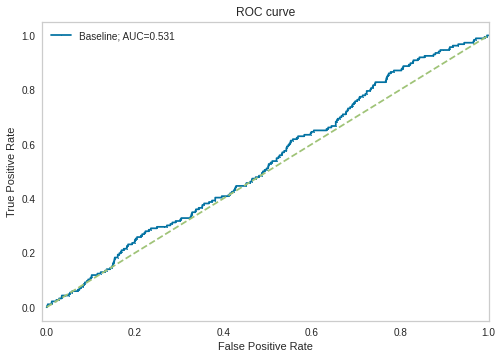

In [180]:
def plot_roc(y_trues, y_preds, labels, x_max=1.0):
    fig, ax = plt.subplots()
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax.plot(fpr, tpr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)

    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')

plot_roc(
    [holdout_data.get_label()],
    [model.predict_proba(holdout_data)[:,1]],
    ['Baseline']
)

In [181]:
!pip3 install shap
import scipy.stats as stats
import shap
shap.initjs()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


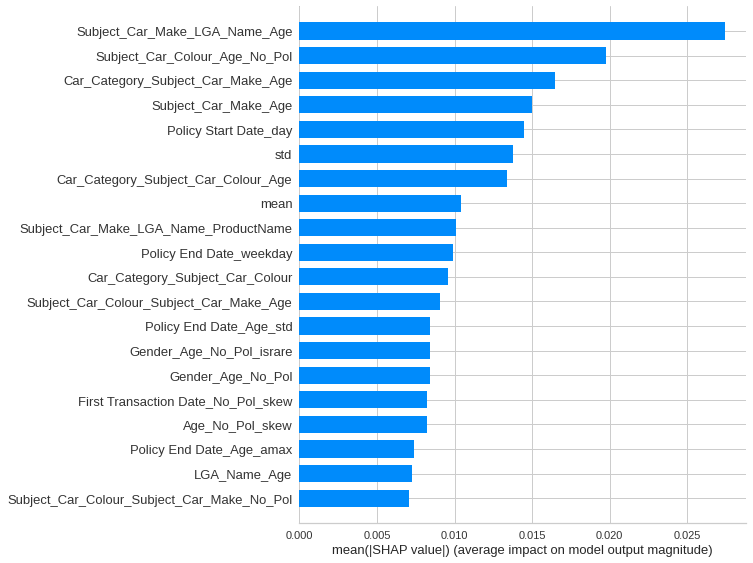

In [182]:
def plot_importances(model, holdout_data, features):
    shap_values = model.get_feature_importance(holdout_data, type='ShapValues')
    expected_value = shap_values[0,-1]
    shap_values = shap_values[:,:-1]
    shap.summary_plot(shap_values, holdout_data, feature_names=features, plot_type='bar')
    
plot_importances(model, holdout_data, features)

In [183]:
class_weight

<module 'sklearn.utils.class_weight' from '/usr/local/lib/python3.7/dist-packages/sklearn/utils/class_weight.py'>

In [184]:
# Select main columns to be used in training
# main_cols = all_data.columns.difference(date_cols+['ID', 'target'])
X = train_df[main_cols]
y = train_df.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42, stratify=y)

# Train model
# smote = SMOTE()
# X_train, y_train = smote.fit_resample(X_train, y_train)
# model = LGBMClassifier()

weight = class_weight.compute_class_weight('balanced', classes=np.unique(y),y=y)
weight = dict(enumerate(weight))

model = LGBMClassifier(class_weight=dict(weight))
# model = CatBoostClassifier(silent=True, class_weights=dict(weight))
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')

F1 score on the X_test is: 0.6079664570230608


In [185]:


%%time
def f2_measure(y_true, y_pred):
    return f1_score(y_true, y_pred)
scoring = make_scorer(f2_measure)

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)
# sel = SelectFromModel(
#     PermutationImportance(LGBMClassifier(class_weight=dict(weight)),cv=cv, scoring=scoring), 
#     threshold=0.0005).fit(X, y)
# feature_idx = sel.get_support()
# feature_name = X.columns[feature_idx]
# feature_name
model = LGBMClassifier(class_weight=dict(weight))
# model.fit(X_train, y_train)
perm = PermutationImportance(model, cv=cv, scoring=scoring, random_state=42).fit(X, y)#.fit(X_test, y_test)

weights_df = eli5.explain_weights_df(perm, feature_names = X_train.columns.tolist())
weights_df[weights_df.weight>0.005]

CPU times: user 5min 4s, sys: 2.17 s, total: 5min 6s
Wall time: 2min 55s


In [186]:
main_cols = weights_df[weights_df.weight>0.0005].feature.tolist()
# main_cols = feature_name.tolist()
len(main_cols)

66

In [187]:
main_cols

['Subject_Car_Make_imputed',
 'Subject_Car_Make_ProductName_No_Pol',
 'Subject_Car_Make_Age_No_Pol',
 'LGA_Name_Age_No_Pol',
 'Gender_Subject_Car_Make_Age',
 'Gender_ProductName_Age',
 'Subject_Car_Colour_LGA_Name_Age',
 'Subject_Car_Make_LGA_Name_Age',
 'Subject_Car_Colour_Subject_Car_Make_Age',
 'ProductName_Age_No_Pol',
 'Policy End Date_day_cos',
 'Car_Category_LGA_Name_Age',
 'Gender_Subject_Car_Colour_Age',
 'Age_No_Pol',
 'Car_Category_Subject_Car_Make_Age',
 'Car_Category_ProductName_Age',
 'Car_Category_Subject_Car_Colour_Subject_Car_Make',
 'Subject_Car_Make_LGA_Name_No_Pol',
 'First Transaction Date_Age_median',
 'Subject_Car_Make_ProductName_Age',
 'LGA_Name_ProductName_Age',
 'Gender_LGA_Name_Age',
 'Car_Category_Subject_Car_Make_LGA_Name',
 'policy_duration_days',
 'Car_Category_Age_No_Pol',
 'Subject_Car_Colour_Age_mean',
 'Car_Category_Subject_Car_Colour_Age',
 'Policy End Date_No_Pol_kurt',
 'Subject_Car_Colour_Age_No_Pol',
 'Gender_Subject_Car_Colour_Subject_Car_Make'

In [189]:
X = train_df[main_cols]
y = train_df.target

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42, stratify=y)
weight = class_weight.compute_class_weight('balanced', classes = np.unique(y),y = y)
weight = dict(enumerate(weight))

model = LGBMClassifier(class_weight=dict(weight))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')

F1 score on the X_test is: 0.5985090521831736


In [190]:
def f2_measure(y_true, y_pred):
    return f1_score(y_true, y_pred)

def get_models():
    models = list()
    models.append(('lgbm', LGBMClassifier()))
    models.append(('cat', CatBoostClassifier()))
#     models.append(('xgb', XGBClassifier()))
#     models.append(('rf',  RandomForestClassifier()))
    
    return models

def evaluate_models(models, xtrain, xval, ytrain, yval):
    scores = list()
    for name, model in models:
        model.fit(xtrain, ytrain)
        yhat = model.predict_proba(xval)
        yhat = yhat[:, 1]
        
        precision, recall, thresholds = precision_recall_curve(yval, yhat)
        fscore = [f2_measure(yval, to_labels(yhat, t)) for t in thresholds]
        ix = np.nanargmax(fscore)
        
        f1 = f2_measure(yval, to_labels(yhat, thresholds[ix]))
        print(f'{name}: {f1}')
        scores.append(f1)
    return scores

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')


In [191]:
X, y = train_df[main_cols], train_df.target
Xfull, Xtest, yfull, ytest = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
Xtrain, Xval, ytrain, yval = train_test_split(Xfull, yfull, test_size=0.15, random_state=42, stratify=yfull)
Xfull, yfull, Xtest, ytest = Xfull.values, yfull.values, Xtest.values, ytest.values
Xtrain, ytrain, Xval, yval = Xtrain.values, ytrain.values, Xval.values, yval.values

In [193]:
models = get_models()

# count examples in each class
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

weight = class_weight.compute_class_weight('balanced', classes=np.unique(y),y=y)
weight = dict(enumerate(weight))
models[0][1].set_params(class_weight=dict(weight))
models[1][1].set_params(silent=True, class_weights=dict(weight))

# scores = evaluate_models(models, Xtrain, Xval, ytrain, yval)
# print(scores)
# ensemble = VotingClassifier(estimators=models, voting='soft', weights=scores)
ensemble = models[0][1].set_params(class_weight=dict(weight))
ensemble.fit(Xfull, yfull) 
yhat = ensemble.predict_proba(Xtest)

yhat = yhat[:, 1]

# fpr, tpr, thresholds = roc_curve(ytest, yhat)
precision, recall, thresholds = precision_recall_curve(ytest, yhat)
fscore = [f2_measure(ytest, to_labels(yhat, t)) for t in thresholds]
# fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
print('Best Threshold=%f, F-measure=%.3f' % (thresholds[ix], fscore[ix]))
print('Voting: %.3f' % (f2_measure(ytest, to_labels(yhat, thresholds[ix]))))
print(log_loss(ytest, yhat))

print(classification_report(ytest, to_labels(yhat, thresholds[ix])))
print(confusion_matrix(ytest, to_labels(yhat, thresholds[ix])))

Estimate: 7.209
Best Threshold=0.581721, F-measure=0.598
Voting: 0.598
0.24281965641655157
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      4783
         1.0       0.60      0.60      0.60       664

    accuracy                           0.90      5447
   macro avg       0.77      0.77      0.77      5447
weighted avg       0.90      0.90      0.90      5447

[[4514  269]
 [ 266  398]]


In [194]:
models2 = {
    "lgbm": LGBMClassifier,
    "cat": CatBoostClassifier,
#     "rf": RandomForestClassifier,
#     "xgb": XGBClassifier,
}
scoring = make_scorer(f2_measure)

def search_space(model):
    space = {}
    
    if model == 'lgbm':
        space = {
            'max_depth': hp.choice('max_depth', [25, 50, 75]),
            'n_estimators':hp.choice('n_estimators', [250, 500, 750,1000,1500, 2000]),
            'boosting_type':hp.choice('boosting_type',['gbdt', 'dart']),
            'learning_rate': hp.uniform('learning_rate', 0.001, 0.2),
            'num_leaves': hp.choice('num_leaves', [25, 50, 75, 100]),
            'subsample':hp.uniform('subsample', 0.60, 0.95),
            'colsample_bytree':hp.uniform('colsample_bytree', 0.60, 0.95),
        }
    elif model == 'cat':
        space = {
            'iterations': hp.choice('iterations', [250, 500,750,1000,1500]),
            'learning_rate': hp.uniform('learning_rate', 0.001, 0.2),
            'l2_leaf_reg': hp.choice('l2_leaf_reg', [1,4,9]),
            'subsample':hp.uniform('subsample', 0.60, 0.95),
        }
    elif model == 'xgb':
        space = {
            'learning_rate': hp.choice('learning_rate', [0.03 ,0.1, 0.15, 0.2]),
        }
        
    elif model == 'rf':
        space = {
            'max_depth': hp.choice('max_depth', [25, 50, 75]),
            'n_estimators':hp.choice('n_estimators', [250, 500,1000, 1500]),
            'min_samples_leaf': hp.choice('min_samples_leaf', [1, 2, 5, 10]),
            'min_samples_split': hp.choice('min_samples_split', [2, 5, 10, 15, 100]),
        }
        
    space['model'] = model
    
    return space

In [196]:
scoring = make_scorer(f2_measure)

def optimize(params, x, y, pos): 
    model = params.get('model')
    name = params['model']
    del params['model']
    model = models2[model]()
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)
    
    weight = class_weight.compute_class_weight('balanced', classes=np.unique(y),y=y)
    weight = dict(enumerate(weight))
    
    if name == 'lgbm':
        model.set_params(class_weight=dict(weight), **params)
#         model.set_params(**params)
    elif name=='cat':
        model.set_params(silent=True, class_weights=dict(weight), **params)
#         model.set_params(silent=True, **params)
    elif name=='xgb':
        model.set_params(nthread=-1, n_jobs=-1, scale_pos_weight=pos, **params)
        
    elif name=='rf':
        model.set_params(class_weight=dict(weight), **params)
    
    score = cross_val_score(model, x, y, cv=cv, scoring=scoring, n_jobs=-1).mean()
        
    return -1 * score

X, y = train_df[main_cols].values, train_df.target.values
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]

best_params = {}
for k, _ in models2.items():
    params = search_space(k)
    optimization_function = partial(optimize, x=X, y=y, pos=estimate)
    trials = Trials()
    hopt = fmin(fn=optimization_function, 
            space=params, 
            algo=tpe.suggest, 
            max_evals=15, 
            trials=trials )
    del params['model']
    best_params[k] = space_eval(params, hopt)
    print("%s best_params: %s"%(k, best_params[k]))

100%|██████████| 15/15 [20:07<00:00, 80.49s/it, best loss: -0.6163669449677098]
lgbm best_params: {'boosting_type': 'dart', 'colsample_bytree': 0.610453716434621, 'learning_rate': 0.009572748129800183, 'max_depth': 25, 'n_estimators': 1500, 'num_leaves': 100, 'subsample': 0.8268745332064021}
100%|██████████| 15/15 [14:16<00:00, 57.12s/it, best loss: -0.6145044172113678]
cat best_params: {'iterations': 500, 'l2_leaf_reg': 4, 'learning_rate': 0.059533859697058704, 'subsample': 0.7352479626637929}


In [200]:
best_params


{'cat': {'iterations': 500,
  'l2_leaf_reg': 4,
  'learning_rate': 0.059533859697058704,
  'subsample': 0.7352479626637929},
 'lgbm': {'boosting_type': 'dart',
  'colsample_bytree': 0.610453716434621,
  'learning_rate': 0.009572748129800183,
  'max_depth': 25,
  'n_estimators': 1500,
  'num_leaves': 100,
  'subsample': 0.8268745332064021}}

In [201]:
def get_models2():
    models = list()
    models.append(('lgbm', LGBMClassifier()))
    models.append(('cat', CatBoostClassifier()))
#     models.append(('xgb', XGBClassifier()))
#     models.append(('rf', RandomForestClassifier()))
    
    return models

X, y = train_df[main_cols], train_df.target
Xfull, Xtest, yfull, ytest = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
Xtrain, Xval, ytrain, yval = train_test_split(Xfull, yfull, test_size=0.15, random_state=42, stratify=yfull)
X, y = X.values, y.values
Xfull, yfull, Xtest, ytest = Xfull.values, yfull.values, Xtest.values, ytest.values
Xtrain, ytrain, Xval, yval = Xtrain.values, ytrain.values, Xval.values, yval.values

In [203]:
models = get_models2()
lgbm = best_params['lgbm']
cat = best_params['cat']
# rf = best_params['rf']
# xgb = best_params['xgb']

weight = class_weight.compute_class_weight('balanced', classes=np.unique(y),y=y)
weight = dict(enumerate(weight))
models[0][1].set_params(class_weight=dict(weight), **lgbm)
models[1][1].set_params(silent=True, early_stopping_rounds=100, class_weights=dict(weight), **cat)
# models[2][1].set_params(nthread=-1, n_jobs=-1, scale_pos_weight=estimate)
# models[2][1].set_params(class_weight=dict(weight), **rf)

scores = evaluate_models(models, Xtrain, Xval, ytrain, yval)
print(scores)

ensemble = VotingClassifier(estimators=models, voting='soft', weights=scores)
ensemble.fit(Xfull, yfull) 
yhat = ensemble.predict_proba(Xtest)
yhat = yhat[:, 1]
_, _, thresholds = precision_recall_curve(ytest, yhat)
fscore = [f2_measure(ytest, to_labels(yhat, t)) for t in thresholds]
ix = np.nanargmax(fscore)
print('Best Threshold=%f, F-measure=%.3f' % (thresholds[ix], fscore[ix]))
print('Model: %.3f' % (f2_measure(ytest, to_labels(yhat, thresholds[ix]))))
print(log_loss(ytest, yhat))

print(classification_report(ytest, to_labels(yhat, thresholds[ix])))
print(confusion_matrix(ytest, to_labels(yhat, thresholds[ix])))

lgbm: 0.6518518518518519
cat: 0.6030534351145038
[0.6518518518518519, 0.6030534351145038]
Best Threshold=0.478624, F-measure=0.623
Model: 0.623
0.2300446625913093
              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94      3827
         1.0       0.57      0.68      0.62       531

    accuracy                           0.90      4358
   macro avg       0.76      0.81      0.78      4358
weighted avg       0.91      0.90      0.90      4358

[[3555  272]
 [ 168  363]]


In [204]:
models = get_models2()


In [205]:
models


[('lgbm', LGBMClassifier()),
 ('cat', <catboost.core.CatBoostClassifier at 0x7f458fcfeb10>)]

In [207]:
models = get_models2()
folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=5)
oof_preds = np.zeros((len(train_df), 1))
test_preds = np.zeros((len(test_df), 1))
thresholds_ = list()
fscores_ = list()

X, y = train_df[main_cols].values, train_df.target.values
Xtest = test_df[main_cols].values

# count examples in each class
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
weight = class_weight.compute_class_weight('balanced', classes=np.unique(y),y=y)
weight = dict(enumerate(weight))
models[0][1].set_params(class_weight=dict(weight), **lgbm)
models[1][1].set_params(silent=True, early_stopping_rounds=100, class_weights=dict(weight), **cat)

# model = models[1][1].set_params(silent=True, early_stopping_rounds=100, class_weights=dict(weight), **cat)
for idx in tqdm(folds.split(X, y), total=folds.get_n_splits(), desc="rs-fold"):
    train_idx, val_idx = idx[0], idx[1]
    xtrain, ytrain = X[train_idx], y[train_idx]
    xval, yval = X[val_idx], y[val_idx]
    
    scores = evaluate_models(models, xtrain, xval, ytrain, yval)
    model = VotingClassifier(estimators=models, voting='soft', weights=scores)
    model.fit(xtrain, ytrain)
    val_preds = model.predict_proba(xval)
    test_fold_pred = model.predict_proba(Xtest)
    
    test_fold_pred = test_fold_pred[:,1]
    val_preds = val_preds[:,1]
    
    _, _, thresholds = precision_recall_curve(yval, val_preds)
    fscore = [f2_measure(yval, to_labels(val_preds, t)) for t in thresholds]
    ix = np.nanargmax(fscore)
    thresholds_.append(thresholds[ix])
    fscores_.append(fscore[ix])
    
    oof_preds[val_idx, :] = val_preds.reshape((-1, 1))
    test_preds += test_fold_pred.reshape((-1, 1))
    
    print('Best Threshold=%f, F-measure=%.3f' % (thresholds[ix], fscore[ix]))
    
test_preds /= folds.get_n_splits()
threshold = sum(thresholds_)/len(thresholds_)
predictions = to_labels(test_preds.ravel(), threshold)
print('f-measure: %.3f' % (f2_measure(y, to_labels(oof_preds.ravel(), thresholds[ix]))))
print(log_loss(y, oof_preds.ravel()))
print(classification_report(y, to_labels(oof_preds.ravel(), thresholds[ix])))
print(confusion_matrix(y, to_labels(oof_preds.ravel(), thresholds[ix])))

rs-fold:   0%|          | 0/50 [00:00<?, ?it/s]

lgbm: 0.6360424028268551
cat: 0.6352941176470588


rs-fold:   2%|▏         | 1/50 [02:06<1:43:28, 126.70s/it]

Best Threshold=0.616939, F-measure=0.623
lgbm: 0.6447761194029851
cat: 0.6583850931677019


rs-fold:   4%|▍         | 2/50 [03:57<1:33:42, 117.14s/it]

Best Threshold=0.432195, F-measure=0.651
lgbm: 0.6666666666666667
cat: 0.6910299003322259


rs-fold:   6%|▌         | 3/50 [05:46<1:29:07, 113.77s/it]

Best Threshold=0.542093, F-measure=0.676
lgbm: 0.6213592233009708
cat: 0.6233766233766234


rs-fold:   8%|▊         | 4/50 [07:36<1:25:51, 111.99s/it]

Best Threshold=0.400337, F-measure=0.629
lgbm: 0.5818181818181818
cat: 0.5993031358885017


rs-fold:  10%|█         | 5/50 [09:25<1:23:22, 111.18s/it]

Best Threshold=0.504746, F-measure=0.599
lgbm: 0.6796875
cat: 0.6619718309859155


rs-fold:  12%|█▏        | 6/50 [11:14<1:21:00, 110.47s/it]

Best Threshold=0.614019, F-measure=0.675
lgbm: 0.6215139442231076
cat: 0.6269592476489028


rs-fold:  14%|█▍        | 7/50 [13:05<1:19:05, 110.37s/it]

Best Threshold=0.611558, F-measure=0.627
lgbm: 0.6714285714285714
cat: 0.6454545454545455


rs-fold:  16%|█▌        | 8/50 [14:55<1:17:12, 110.31s/it]

Best Threshold=0.746296, F-measure=0.661
lgbm: 0.6197183098591549
cat: 0.6484848484848484


rs-fold:  18%|█▊        | 9/50 [16:44<1:15:12, 110.07s/it]

Best Threshold=0.519317, F-measure=0.644
lgbm: 0.6086956521739131
cat: 0.6137184115523466


rs-fold:  20%|██        | 10/50 [18:34<1:13:22, 110.06s/it]

Best Threshold=0.592897, F-measure=0.618
lgbm: 0.616822429906542
cat: 0.6470588235294118


rs-fold:  22%|██▏       | 11/50 [20:25<1:11:36, 110.17s/it]

Best Threshold=0.526581, F-measure=0.637
lgbm: 0.6603174603174603
cat: 0.6646884272997032


rs-fold:  24%|██▍       | 12/50 [22:15<1:09:44, 110.12s/it]

Best Threshold=0.487496, F-measure=0.678
lgbm: 0.6436781609195402
cat: 0.6412213740458015


rs-fold:  26%|██▌       | 13/50 [24:06<1:08:01, 110.32s/it]

Best Threshold=0.587966, F-measure=0.641
lgbm: 0.6040816326530611
cat: 0.5947955390334572


rs-fold:  28%|██▊       | 14/50 [25:57<1:06:22, 110.64s/it]

Best Threshold=0.683501, F-measure=0.614
lgbm: 0.641509433962264
cat: 0.6615969581749049


rs-fold:  30%|███       | 15/50 [27:49<1:04:46, 111.04s/it]

Best Threshold=0.614795, F-measure=0.662
lgbm: 0.6456692913385826
cat: 0.6204379562043796


rs-fold:  32%|███▏      | 16/50 [29:41<1:03:04, 111.30s/it]

Best Threshold=0.512601, F-measure=0.631
lgbm: 0.7251908396946564
cat: 0.7083333333333333


rs-fold:  34%|███▍      | 17/50 [31:31<1:01:05, 111.08s/it]

Best Threshold=0.619483, F-measure=0.726
lgbm: 0.5993265993265994
cat: 0.6291390728476821


rs-fold:  36%|███▌      | 18/50 [33:23<59:14, 111.07s/it]  

Best Threshold=0.434640, F-measure=0.611
lgbm: 0.6349206349206349
cat: 0.6394557823129252


rs-fold:  38%|███▊      | 19/50 [35:14<57:30, 111.32s/it]

Best Threshold=0.561939, F-measure=0.638
lgbm: 0.6692307692307692
cat: 0.672


rs-fold:  40%|████      | 20/50 [37:06<55:41, 111.40s/it]

Best Threshold=0.599974, F-measure=0.677
lgbm: 0.6307692307692307
cat: 0.6219081272084805


rs-fold:  42%|████▏     | 21/50 [38:56<53:39, 111.02s/it]

Best Threshold=0.670984, F-measure=0.623
lgbm: 0.5928338762214983
cat: 0.5966101694915255


rs-fold:  44%|████▍     | 22/50 [40:46<51:40, 110.74s/it]

Best Threshold=0.383566, F-measure=0.594
lgbm: 0.6349206349206349
cat: 0.6242424242424243


rs-fold:  46%|████▌     | 23/50 [42:38<50:00, 111.12s/it]

Best Threshold=0.464675, F-measure=0.637
lgbm: 0.6986301369863013
cat: 0.6931407942238267


rs-fold:  48%|████▊     | 24/50 [44:29<48:09, 111.15s/it]

Best Threshold=0.558119, F-measure=0.703
lgbm: 0.6578947368421052
cat: 0.6227106227106227


rs-fold:  50%|█████     | 25/50 [46:21<46:24, 111.39s/it]

Best Threshold=0.672314, F-measure=0.640
lgbm: 0.5818181818181819
cat: 0.5961538461538463


rs-fold:  52%|█████▏    | 26/50 [48:13<44:35, 111.50s/it]

Best Threshold=0.707606, F-measure=0.593
lgbm: 0.6714801444043321
cat: 0.6795366795366795


rs-fold:  54%|█████▍    | 27/50 [50:05<42:48, 111.66s/it]

Best Threshold=0.606835, F-measure=0.682
lgbm: 0.6666666666666667
cat: 0.6600660066006602


rs-fold:  56%|█████▌    | 28/50 [51:57<40:54, 111.59s/it]

Best Threshold=0.586436, F-measure=0.661
lgbm: 0.6228373702422145
cat: 0.621160409556314


rs-fold:  58%|█████▊    | 29/50 [53:48<39:01, 111.48s/it]

Best Threshold=0.534527, F-measure=0.616
lgbm: 0.6037735849056604
cat: 0.6325878594249201


rs-fold:  60%|██████    | 30/50 [55:40<37:13, 111.65s/it]

Best Threshold=0.504214, F-measure=0.623
lgbm: 0.6589147286821705
cat: 0.6463878326996199


rs-fold:  62%|██████▏   | 31/50 [57:30<35:14, 111.27s/it]

Best Threshold=0.544118, F-measure=0.653
lgbm: 0.6594202898550725
cat: 0.689922480620155


rs-fold:  64%|██████▍   | 32/50 [59:22<33:23, 111.28s/it]

Best Threshold=0.658343, F-measure=0.697
lgbm: 0.6419753086419753
cat: 0.6421404682274247


rs-fold:  66%|██████▌   | 33/50 [1:01:14<31:37, 111.64s/it]

Best Threshold=0.526600, F-measure=0.648
lgbm: 0.6351351351351352
cat: 0.6478873239436619


rs-fold:  68%|██████▊   | 34/50 [1:03:06<29:46, 111.67s/it]

Best Threshold=0.534472, F-measure=0.646
lgbm: 0.6086956521739131
cat: 0.615916955017301


rs-fold:  70%|███████   | 35/50 [1:04:58<27:56, 111.76s/it]

Best Threshold=0.482841, F-measure=0.612
lgbm: 0.6691729323308271
cat: 0.657243816254417


rs-fold:  72%|███████▏  | 36/50 [1:06:49<26:03, 111.67s/it]

Best Threshold=0.583282, F-measure=0.662
lgbm: 0.6214285714285714
cat: 0.6254295532646048


rs-fold:  74%|███████▍  | 37/50 [1:08:42<24:14, 111.88s/it]

Best Threshold=0.708903, F-measure=0.625
lgbm: 0.5864661654135338
cat: 0.631578947368421


rs-fold:  76%|███████▌  | 38/50 [1:10:33<22:19, 111.61s/it]

Best Threshold=0.635065, F-measure=0.617
lgbm: 0.6428571428571429
cat: 0.664092664092664


rs-fold:  78%|███████▊  | 39/50 [1:12:25<20:30, 111.88s/it]

Best Threshold=0.666085, F-measure=0.651
lgbm: 0.6829268292682926
cat: 0.68


rs-fold:  80%|████████  | 40/50 [1:14:15<18:34, 111.42s/it]

Best Threshold=0.464683, F-measure=0.690
lgbm: 0.6101694915254238
cat: 0.6275862068965516


rs-fold:  82%|████████▏ | 41/50 [1:16:05<16:39, 111.01s/it]

Best Threshold=0.461296, F-measure=0.625
lgbm: 0.6195286195286195
cat: 0.6264150943396226


rs-fold:  84%|████████▍ | 42/50 [1:17:58<14:51, 111.40s/it]

Best Threshold=0.452965, F-measure=0.619
lgbm: 0.6084142394822006
cat: 0.629757785467128


rs-fold:  86%|████████▌ | 43/50 [1:19:51<13:02, 111.80s/it]

Best Threshold=0.484162, F-measure=0.617
lgbm: 0.6330935251798561
cat: 0.6451612903225807


rs-fold:  88%|████████▊ | 44/50 [1:21:43<11:12, 112.06s/it]

Best Threshold=0.529046, F-measure=0.638
lgbm: 0.6590038314176245
cat: 0.6666666666666666


rs-fold:  90%|█████████ | 45/50 [1:23:34<09:18, 111.74s/it]

Best Threshold=0.642628, F-measure=0.667
lgbm: 0.6444444444444444
cat: 0.6352941176470588


rs-fold:  92%|█████████▏| 46/50 [1:25:26<07:27, 111.89s/it]

Best Threshold=0.634810, F-measure=0.640
lgbm: 0.6666666666666667
cat: 0.6837606837606838


rs-fold:  94%|█████████▍| 47/50 [1:27:18<05:35, 111.89s/it]

Best Threshold=0.723977, F-measure=0.670
lgbm: 0.6474358974358975
cat: 0.6621160409556314


rs-fold:  96%|█████████▌| 48/50 [1:29:10<03:43, 111.84s/it]

Best Threshold=0.468944, F-measure=0.660
lgbm: 0.7063197026022305
cat: 0.6976744186046512


rs-fold:  98%|█████████▊| 49/50 [1:31:02<01:51, 111.90s/it]

Best Threshold=0.627074, F-measure=0.703
lgbm: 0.643478260869565
cat: 0.6215139442231076


rs-fold: 100%|██████████| 50/50 [1:32:54<00:00, 111.49s/it]

Best Threshold=0.640186, F-measure=0.632
f-measure: 0.634
0.23540640224813428
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95      9566
         1.0       0.66      0.61      0.63      1327

    accuracy                           0.91     10893
   macro avg       0.80      0.78      0.79     10893
weighted avg       0.91      0.91      0.91     10893

[[9155  411]
 [ 521  806]]


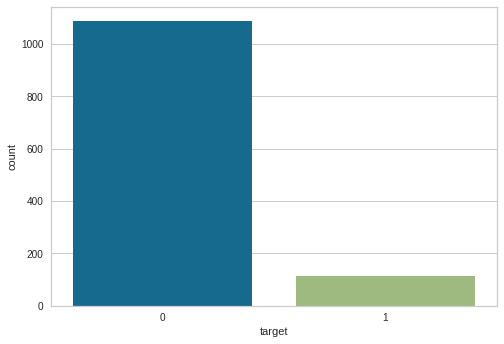

In [208]:
# Make prediction on the test set
# test_df = test_df[main_cols]
# predictions = model.predict(test_df)

# Create a submission file
sub_file = submission.copy()
sub_file.target = predictions

# Check the distribution of your predictions
sns.countplot(sub_file.target);

In [209]:
# Create a csv file and upload to zindi 
sub_file.to_csv('submission_voting_clf.csv', index = False)